<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/German_credit_exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#2/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Explore data

In [120]:
credit = pd.read_csv('/content/drive/MyDrive/Mirthe_Supervision /Paper#2/Colab Notebooks/german_processed.csv')
credit.info()
credit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   GoodCustomer                     1000 non-null   int64 
 1   Gender                           1000 non-null   object
 2   ForeignWorker                    1000 non-null   int64 
 3   Single                           1000 non-null   int64 
 4   Age                              1000 non-null   int64 
 5   LoanDuration                     1000 non-null   int64 
 6   PurposeOfLoan                    1000 non-null   object
 7   LoanAmount                       1000 non-null   int64 
 8   LoanRateAsPercentOfIncome        1000 non-null   int64 
 9   YearsAtCurrentHome               1000 non-null   int64 
 10  NumberOfOtherLoansAtBank         1000 non-null   int64 
 11  NumberOfLiableIndividuals        1000 non-null   int64 
 12  HasTelephone                     10

,GoodCustomer,Gender,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,...,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled
0,1,Male,0,1,67,6,Electronics,1169,4,4,...,0,0,0,0,1,0,0,0,1,1
1,-1,Female,0,0,22,48,Electronics,5951,2,2,...,0,0,0,0,1,0,0,0,0,1
2,1,Male,0,1,49,12,Education,2096,2,3,...,0,0,0,0,1,0,0,0,1,0
3,1,Male,0,1,45,42,Furniture,7882,2,4,...,0,0,0,1,0,0,0,0,1,1
4,-1,Male,0,1,53,24,NewCar,4870,3,4,...,0,0,0,0,0,0,0,0,0,1


In [121]:
credit['GoodCustomer'] = credit['GoodCustomer'].replace(-1,0)
credit['GoodCustomer'].value_counts()

,count
GoodCustomer,
1,700
0,300


In [122]:
credit['PurposeOfLoan'].unique()
credit['CheckingAccountBalance_geq_0'].unique()
credit['ForeignWorker'].unique()
credit['LoanDuration'].nunique()

33

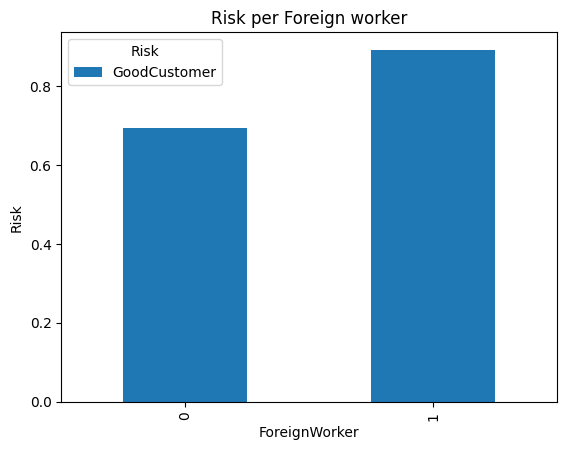

In [123]:
risk_per_foreign_worker = credit.groupby('ForeignWorker')['GoodCustomer'].mean()
risk_per_foreign_worker.plot(kind='bar', stacked=True)
plt.title('Risk per Foreign worker')

plt.xlabel('ForeignWorker')
plt.ylabel('Risk')
plt.legend(title='Risk')
plt.show()

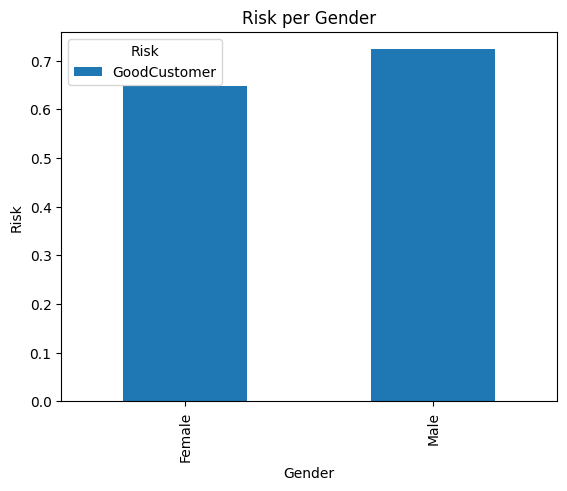

In [124]:
risk_per_gender = credit.groupby('Gender')['GoodCustomer'].mean()
risk_per_gender.plot(kind='bar', stacked=True)
plt.title('Risk per Gender')

plt.xlabel('Gender')
plt.ylabel('Risk')
plt.legend(title='Risk')
plt.show()

Text(0, 0.5, 'Risk')

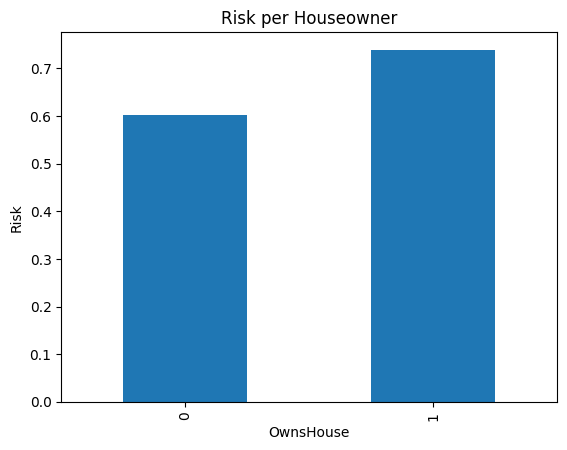

In [125]:
risk_per_houseowner = credit.groupby('OwnsHouse')['GoodCustomer'].mean()
risk_per_houseowner.plot(kind='bar', stacked=True)
plt.title('Risk per Houseowner')

plt.xlabel('OwnsHouse')
plt.ylabel('Risk')

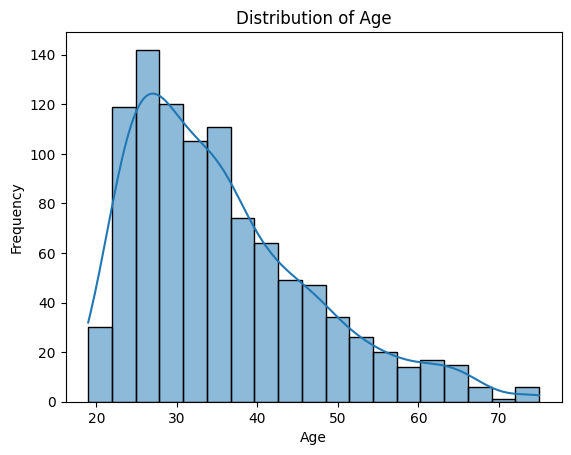

In [126]:
# Plot the distribution of 'Age' using a histogram with Seaborn
sns.histplot(credit['Age'], kde=True)  # kde=True adds a kernel density estimate
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Master dataset

In [154]:
#Master Dataset
#FEATURES
META = ['clusters', 'new_clusters', 'Error_Type']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = ['Age', 'Single', 'Unemployed', 'LoanAmount']
#SEN = ['Gender_F', 'OwnsHouse'] #protected attributes
DUMMY = ['Gender_F', 'OwnsHouse', 'ForeignWorker']

#FEATURES SCALED
ERROR_scaled = ['errors_scaled']
REG_scaled = ['Age_scaled','Single_scaled', 'Unemployed_scaled',
               'LoanAmount_scaled']
#SEN_scaled = ['Gender_F_scaled', 'OwnsHouse_scaled']
DUMMY_scaled = ['Gender_F_scaled', 'OwnsHouse_scaled','ForeignWorker_scaled']

#SHAP FEATURES
SHAP_REG = ['Shap_Age','Shap_Single','Shap_Unemployed', 'Shap_LoanAmount']
#SHAP_SEN = ['Shap_Gender_F', 'Shap_OwnsHouse']
SHAP_DUMMY = ['Shap_Gender_F', 'Shap_OwnsHouse','Shap_ForeignWorker']

#SHAP FEATURES SCALED
SHAP_REG_scaled = ['Shap_Age_scaled', 'Shap_Single_scaled', 'Shap_Unemployed_scaled',
                   'Shap_LoanAmount_scaled']
#SHAP_SEN_scaled = ['Shap_Gender_F_scaled', 'Shap_OwnsHouse_scaled']
SHAP_DUMMY_scaled = ['Shap_Gender_F_scaled', 'Shap_OwnsHouse_scaled', 'Shap_ForeignWorker_scaled']


'''removed_features = 'LoanDuration','PurposeOfLoan','LoanRateAsPercentOfIncome', 'YearsAtCurrentHome',
'NumberOfOtherLoansAtBank', 'NumberOfLiableIndividuals', 'HasTelephone', 'CheckingAccountBalance_geq_0',
'CheckingAccountBalance_geq_200', 'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500', 'MissedPayments',
'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere', 'OtherLoansAtBank', 'OtherLoansAtStore', 'HasCoapplicant',
'HasGuarantor', 'RentsHouse', 'YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4', 'JobClassIsSkilled' '''

"removed_features = 'LoanDuration','PurposeOfLoan','LoanRateAsPercentOfIncome', 'YearsAtCurrentHome',\n'NumberOfOtherLoansAtBank', 'NumberOfLiableIndividuals', 'HasTelephone', 'CheckingAccountBalance_geq_0',\n'CheckingAccountBalance_geq_200', 'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500', 'MissedPayments',\n'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere', 'OtherLoansAtBank', 'OtherLoansAtStore', 'HasCoapplicant',\n'HasGuarantor', 'RentsHouse', 'YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4', 'JobClassIsSkilled' "

In [128]:
removed_features = ['LoanDuration','PurposeOfLoan','LoanRateAsPercentOfIncome', 'YearsAtCurrentHome',
'NumberOfOtherLoansAtBank', 'NumberOfLiableIndividuals', 'HasTelephone', 'CheckingAccountBalance_geq_0',
'CheckingAccountBalance_geq_200', 'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500', 'MissedPayments',
'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere', 'OtherLoansAtBank', 'OtherLoansAtStore', 'HasCoapplicant',
'HasGuarantor', 'RentsHouse', 'YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4', 'JobClassIsSkilled']

credit = credit.drop(removed_features, axis =1)
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   GoodCustomer   1000 non-null   int64 
 1   Gender         1000 non-null   object
 2   ForeignWorker  1000 non-null   int64 
 3   Single         1000 non-null   int64 
 4   Age            1000 non-null   int64 
 5   LoanAmount     1000 non-null   int64 
 6   OwnsHouse      1000 non-null   int64 
 7   Unemployed     1000 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 62.6+ KB


Get dummies for gender

In [129]:
credit['Gender_F'] = (credit['Gender'] == 'Female').astype(int)
credit['Gender_M'] = (credit['Gender'] == 'Male').astype(int)
credit = credit.drop('Gender', axis = 1)
credit.iloc[3]

,3
GoodCustomer,1
ForeignWorker,0
Single,1
Age,45
LoanAmount,7882
OwnsHouse,0
Unemployed,0
Gender_F,0
Gender_M,1


In [130]:
credit['GoodCustomer'].unique()

array([1, 0])

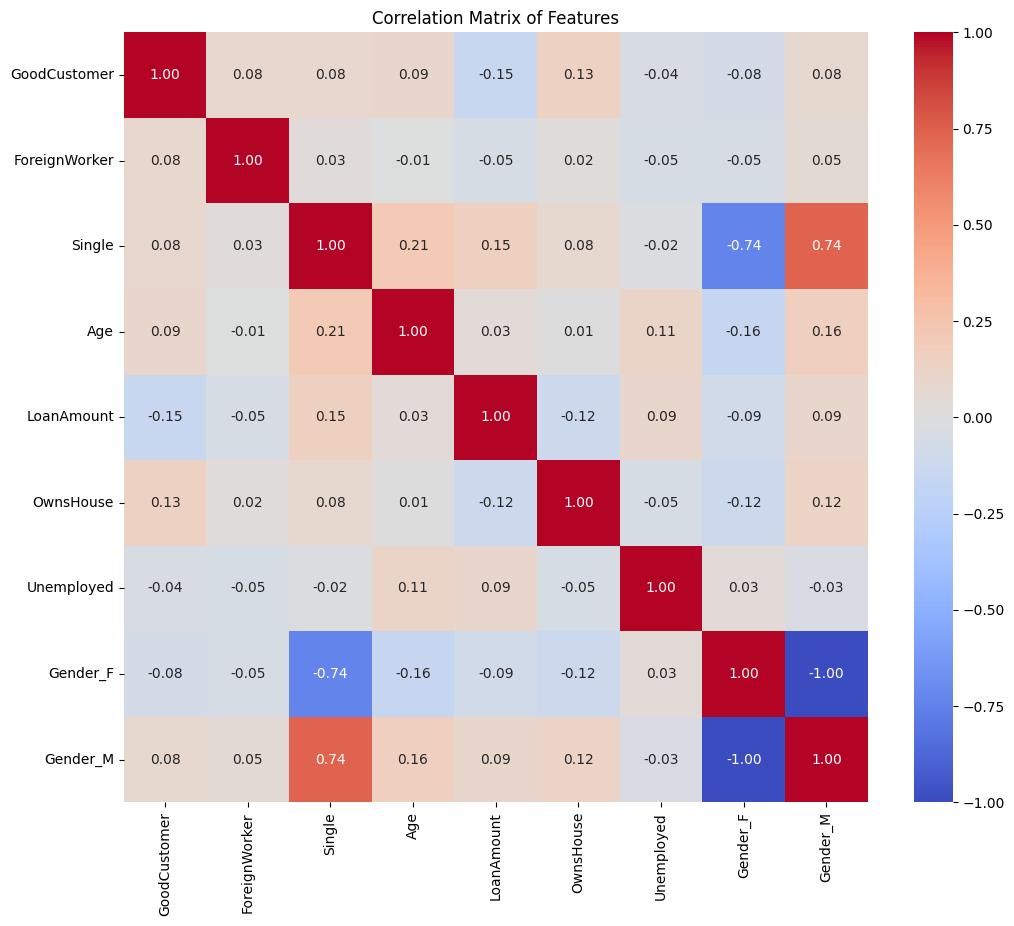

In [131]:
# Calculate correlation matrix for selected columns
correlation_matrix = credit.corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [132]:
#credit = credit.drop('Gender_M', axis = 1)

# Train RF

In [133]:
X = credit.drop(columns = ['GoodCustomer'], axis = 1)
Y = credit['GoodCustomer']
Y.value_counts()

,count
GoodCustomer,
1,700
0,300


In [134]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.7, shuffle = True, stratify = Y)

print("Class distribution in Y_train after upsampling:")
print(Y_train.value_counts())

Class distribution in Y_train after upsampling:
GoodCustomer
1    210
0     90
Name: count, dtype: int64


scale before predicting for shap later

In [135]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)
credit_scaled = pd.concat([pd.DataFrame(X_scaled_train, columns=[col + '_scaled' for col in X.columns]),
                         pd.DataFrame(X_scaled_test, columns=[col + '_scaled' for col in X.columns])])



#merge scaled and unscaled data
credit_sc = pd.merge(credit, credit_scaled, left_index=True, right_index=True)
credit_sc.info()
credit_sc.iloc[3]

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 699
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GoodCustomer          1000 non-null   int64  
 1   ForeignWorker         1000 non-null   int64  
 2   Single                1000 non-null   int64  
 3   Age                   1000 non-null   int64  
 4   LoanAmount            1000 non-null   int64  
 5   OwnsHouse             1000 non-null   int64  
 6   Unemployed            1000 non-null   int64  
 7   Gender_F              1000 non-null   int64  
 8   Gender_M              1000 non-null   int64  
 9   ForeignWorker_scaled  1000 non-null   float64
 10  Single_scaled         1000 non-null   float64
 11  Age_scaled            1000 non-null   float64
 12  LoanAmount_scaled     1000 non-null   float64
 13  OwnsHouse_scaled      1000 non-null   float64
 14  Unemployed_scaled     1000 non-null   float64
 15  Gender_F_scaled       1000 

,1
GoodCustomer,0.000000
ForeignWorker,0.000000
Single,0.000000
Age,22.000000
LoanAmount,5951.000000
OwnsHouse,1.000000
Unemployed,0.000000
Gender_F,1.000000
Gender_M,0.000000
ForeignWorker_scaled,-0.175863


In [136]:
model = RandomForestClassifier()
model.fit(X_scaled_train, Y_train)

#predictions
Yhat = model.predict(X_scaled_test)
len(Yhat)

700

In [137]:
#Create df to contain the predicted and true classes - converting y_hat np to df
predictions = pd.DataFrame()
predictions['predicted_class'] = Yhat.tolist()
predictions = predictions.set_index(X_test.index)
predictions['true_class'] = Y_test

#Calculating the errors with the absolute value
predictions['errors'] = abs(predictions['predicted_class'] - predictions['true_class'])

#adding predictions to test data
X_scaled_test_df = pd.DataFrame(X_scaled_test, columns=[col + '_scaled' for col in X_test.columns], index=X_test.index)
credit_error = pd.concat([X_test, X_scaled_test_df, predictions], axis=1)

errors = credit_error['errors']
df_out = credit_error.drop(['predicted_class', 'true_class', 'errors'], axis=1)
credit_error[credit_error['errors']==1]

#accuracy & confusion matrix
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)

Accuracy: 0.6471
[[ 52 158]
 [ 89 401]]


In [138]:
credit_error.iloc[3]

,654
ForeignWorker,0.000000
Single,1.000000
Age,35.000000
LoanAmount,2346.000000
OwnsHouse,1.000000
Unemployed,0.000000
Gender_F,0.000000
Gender_M,1.000000
ForeignWorker_scaled,-0.175863
Single_scaled,1.054835


# Add Error to Data

In [139]:
#selecting the 4 error labels
def get_error_type(row):
    true_class = row['true_class']
    predicted_class = row['predicted_class']

    if true_class == predicted_class and true_class == 1:
        row['TP'] = 1
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 0
    elif true_class == predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 1
        row['FN'] = 0
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 1:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 1
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 1

    return row

#apply function to rows in data
credit_err = credit_error.apply(get_error_type, axis=1)

#v2_err.info()
credit_err.iloc[3]

,654
ForeignWorker,0.000000
Single,1.000000
Age,35.000000
LoanAmount,2346.000000
OwnsHouse,1.000000
Unemployed,0.000000
Gender_F,0.000000
Gender_M,1.000000
ForeignWorker_scaled,-0.175863
Single_scaled,1.054835


In [140]:
#check if there are any fp/fn at all
if (credit_err['FP'] ==1).any():
  print("there is at least one FP")
else: print("there is no FP")

there is at least one FP


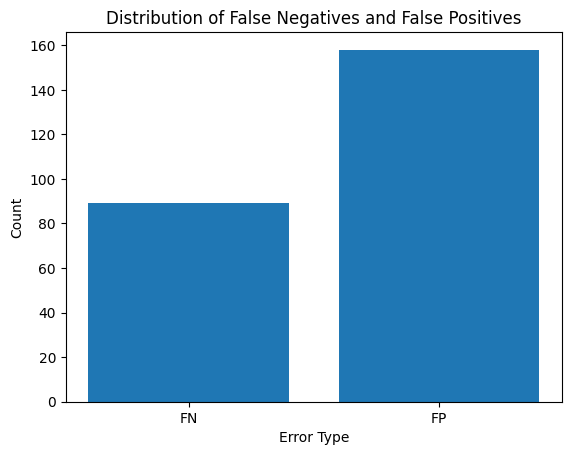

In [141]:
fn_count = credit_err['FN'].sum()
fp_count = credit_err['FP'].sum()

# Create a bar chart
plt.bar(['FN', 'FP'], [fn_count, fp_count])
plt.title('Distribution of False Negatives and False Positives')
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.show()

In [142]:
#add scaled errors as well
errors_col = ['errors', 'TP', 'TN', 'FN', 'FP', 'predicted_class', 'true_class']
df_errors = credit_err[errors_col]
#df_errors.info()

errors_scaled = scaler.fit_transform(df_errors)
errors_scaled_df = pd.DataFrame(errors_scaled, columns=[col + '_scaled' for col in df_errors.columns])
#errors_scaled_df.info()

credit_err_sc = pd.merge(credit_err, errors_scaled_df, left_index=True, right_index=True)
credit_err_sc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 476 entries, 118 to 278
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ForeignWorker           476 non-null    float64
 1   Single                  476 non-null    float64
 2   Age                     476 non-null    float64
 3   LoanAmount              476 non-null    float64
 4   OwnsHouse               476 non-null    float64
 5   Unemployed              476 non-null    float64
 6   Gender_F                476 non-null    float64
 7   Gender_M                476 non-null    float64
 8   ForeignWorker_scaled    476 non-null    float64
 9   Single_scaled           476 non-null    float64
 10  Age_scaled              476 non-null    float64
 11  LoanAmount_scaled       476 non-null    float64
 12  OwnsHouse_scaled        476 non-null    float64
 13  Unemployed_scaled       476 non-null    float64
 14  Gender_F_scaled         476 non-null    float

# Add SHAP values

In [143]:
!pip install shap
import shap

In [144]:
tree_explainer = shap.TreeExplainer(model)
shap_values = tree_explainer.shap_values(X_test, check_additivity=False)

shap_values_class1 = shap_values[:, :, 1] #all samples, all features, class = 1
shap_values_class0 = shap_values[:, :, 0]



In [145]:
df_shap_values = pd.DataFrame(shap_values_class1, columns=[f'Shap_{col}' for col in X_test.columns])
df_shap_values.info()
df_shap_values.iloc[3]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Shap_ForeignWorker  700 non-null    float64
 1   Shap_Single         700 non-null    float64
 2   Shap_Age            700 non-null    float64
 3   Shap_LoanAmount     700 non-null    float64
 4   Shap_OwnsHouse      700 non-null    float64
 5   Shap_Unemployed     700 non-null    float64
 6   Shap_Gender_F       700 non-null    float64
 7   Shap_Gender_M       700 non-null    float64
dtypes: float64(8)
memory usage: 43.9 KB


,3
Shap_ForeignWorker,-0.004854
Shap_Single,-0.006986
Shap_Age,0.030328
Shap_LoanAmount,-0.479538
Shap_OwnsHouse,0.047527
Shap_Unemployed,-0.003577
Shap_Gender_F,-0.018355
Shap_Gender_M,-0.011345


scale shap values

In [146]:
df_shap_scaled = scaler.fit_transform(df_shap_values)
df_all_shap = pd.merge(df_shap_values, pd.DataFrame(df_shap_scaled, columns=[col + '_scaled' for col in df_shap_values.columns]), left_index=True, right_index=True)
df_all_shap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Shap_ForeignWorker         700 non-null    float64
 1   Shap_Single                700 non-null    float64
 2   Shap_Age                   700 non-null    float64
 3   Shap_LoanAmount            700 non-null    float64
 4   Shap_OwnsHouse             700 non-null    float64
 5   Shap_Unemployed            700 non-null    float64
 6   Shap_Gender_F              700 non-null    float64
 7   Shap_Gender_M              700 non-null    float64
 8   Shap_ForeignWorker_scaled  700 non-null    float64
 9   Shap_Single_scaled         700 non-null    float64
 10  Shap_Age_scaled            700 non-null    float64
 11  Shap_LoanAmount_scaled     700 non-null    float64
 12  Shap_OwnsHouse_scaled      700 non-null    float64
 13  Shap_Unemployed_scaled     700 non-null    float64

# Make master dataset

In [147]:
credit_all = pd.merge(credit_err_sc, df_all_shap, left_index=True,right_index=True)
credit_all = credit_all.drop(['predicted_class', 'true_class', 'predicted_class_scaled', 'true_class_scaled'], axis=1)
credit_all.iloc[3]
credit_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 476 entries, 118 to 278
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ForeignWorker              476 non-null    float64
 1   Single                     476 non-null    float64
 2   Age                        476 non-null    float64
 3   LoanAmount                 476 non-null    float64
 4   OwnsHouse                  476 non-null    float64
 5   Unemployed                 476 non-null    float64
 6   Gender_F                   476 non-null    float64
 7   Gender_M                   476 non-null    float64
 8   ForeignWorker_scaled       476 non-null    float64
 9   Single_scaled              476 non-null    float64
 10  Age_scaled                 476 non-null    float64
 11  LoanAmount_scaled          476 non-null    float64
 12  OwnsHouse_scaled           476 non-null    float64
 13  Unemployed_scaled          476 non-null    float64
 1

In [148]:
# Extract dummy variables for error labels
error_type = credit_all[['TP', 'FP', 'FN', 'TN']]

# Convert 'Error_type' column to categorical
credit_all['Error_Type'] = error_type.idxmax(axis=1).astype('category')
credit_all.iloc[3]

,107
ForeignWorker,0.0
Single,1.0
Age,32.0
LoanAmount,6078.0
OwnsHouse,1.0
Unemployed,0.0
Gender_F,0.0
Gender_M,1.0
ForeignWorker_scaled,-0.175863
Single_scaled,1.054835


save to csv

In [149]:
credit_all.to_csv('/content/drive/MyDrive/Mirthe_Supervision /Paper#2/Colab Notebooks/credit_all.csv', index=False)

# tsne

In [150]:
from sklearn.manifold import TSNE

def tsne_plot(data, title, perplexity, learning_rate, n_iter, alpha, tsne_columns, other_columns = None):
    # Ensure tsne_columns is a list and contains valid columns
    if not isinstance(tsne_columns, list):
        raise ValueError("tsne_columns should be a list of column names.")

    # Check if the selected columns are in the dataframe
    for col in tsne_columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' is not in the dataframe.")

    # Initialize other_columns to empty list if not provided
    if other_columns is None:
        other_columns = []

    # Ensure other_columns is a list and contains valid columns
    if not isinstance(other_columns, list):
        raise ValueError("other_columns should be a list of column names.")

    # Exclude tsne_columns from other_columns
    exclude_columns = tsne_columns
    other_columns = [col for col in data.columns if col not in exclude_columns]

    # Extract features for t-SNE and drop Meta_columns
    tsne_features = data[tsne_columns]
    other_features = data[other_columns]

    tsne = TSNE(n_components=2, perplexity= 30, learning_rate= 200, n_iter= 1000)
    tsne_result = tsne.fit_transform(tsne_features)
    tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

    temp_dataset = tsne_df.join(other_features, how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, hue="Error_Type", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


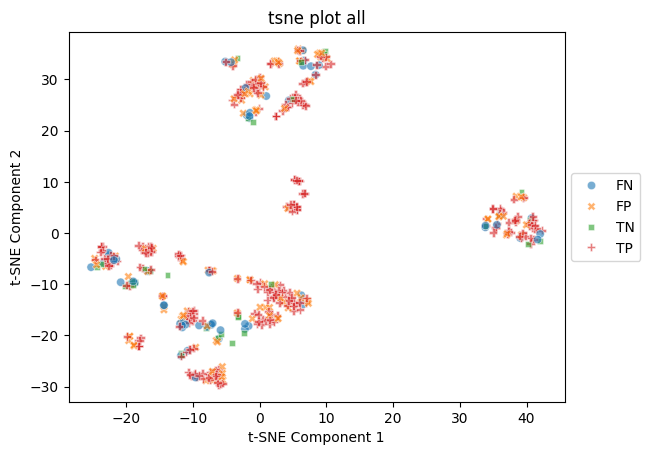

In [151]:
tsne_plot(credit_all, 'tsne plot all', 30, 200, 1000, 0.6, tsne_columns=REG_scaled + DUMMY_scaled + ERROR_scaled+ SHAP_REG_scaled + SHAP_DUMMY_scaled, other_columns= None)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


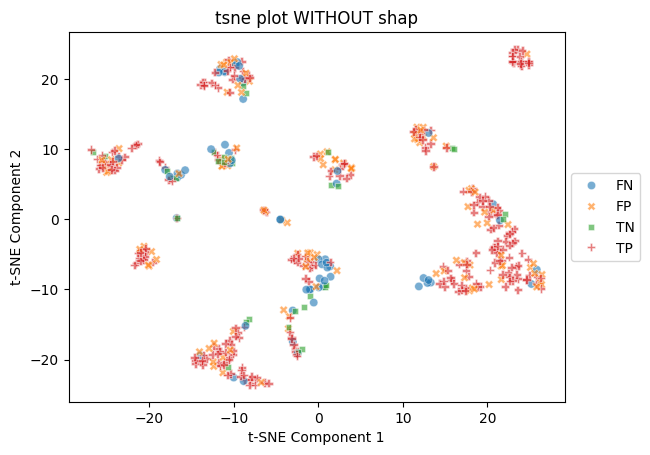

In [153]:
tsne_plot(credit_all, 'tsne plot WITHOUT shap', 30, 200, 1000, 0.6, tsne_columns=REG_scaled + DUMMY_scaled + ERROR_scaled, other_columns= None)
plt.show()